# Historical data

Gathering weather data for time prior to collection from Open Weather Map. 

Data provided by <a href="https://www.meteostat.net" title="meteostat" target="_blank">meteostat</a>. Meteorological data: Copyright &copy; National Oceanic and Atmospheric Administration (NOAA), Deutscher Wetterdienst (DWD). Learn more about the <a href="https://www.meteostat.net/sources" title="meteostat Sources" target="_blank">sources</a>.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import json
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
root_dir = os.path.join(os.getcwd(), '..')
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(root_dir)
sys.path.append(src_dir)

from conf.auth import ms_api_key
from d00_utils.binning import BinTime

In [3]:
station_ids = {
    'JFK': '74486'
}

In [4]:
api_url = '''https://api.meteostat.net/v1/history/hourly?station={}&start=2020-01-01&end=2020-04-13&key={}'''.format(station_ids['JFK'], ms_api_key)

In [5]:
r = requests.get(api_url)

In [6]:
d = json.loads(r.text)

temp_hist = pd.DataFrame(d['data'])
temp_hist = temp_hist.drop(columns=['dewpoint', 'precipitation_3', 'precipitation_6', 'snowdepth', 'peakgust', 'condition'])

In [7]:
# rename columns to follow convention
temp_hist = temp_hist.rename(
    columns={'temperature': 'temp',
             'precipitation': 'rain_1h',
             'windspeed': 'wind_speed',
             'winddirection': 'wind_deg',
             'pressure': 'press'})

In [8]:
# convert to F, in.
temp_hist['temp'] = (temp_hist['temp'] * 1.8) + 32
temp_hist['rain_1h'] = temp_hist['rain_1h'] / 25.4
temp_hist['time'] =  pd.to_datetime(temp_hist['time'])

In [9]:
temp_hist['time_bin'] = BinTime(temp_hist['time'])

In [10]:
temp_hist

,time,temp,humidity,rain_1h,wind_speed,wind_deg,press,time_bin
0,2020-01-01 00:00:00,42.08,89,0.000000,13.0,220,1004.1,2019-12-31 23:50:00
1,2020-01-01 01:00:00,42.98,86,0.000000,16.6,210,1003.7,2020-01-01 00:50:00
2,2020-01-01 02:00:00,44.06,85,0.000000,27.7,250,1004.2,2020-01-01 01:50:00
3,2020-01-01 03:00:00,42.98,73,0.000000,24.1,270,1003.9,2020-01-01 02:50:00
4,2020-01-01 04:00:00,42.98,70,0.000000,27.7,270,1004.0,2020-01-01 03:50:00
...,...,...,...,...,...,...,...,...
2491,2020-04-13 19:00:00,55.94,100,0.039370,53.6,170,999.2,2020-04-13 18:50:00
2492,2020-04-13 20:00:00,55.04,100,0.011811,48.2,180,998.3,2020-04-13 19:50:00
2493,2020-04-13 21:00:00,55.94,100,0.000000,59.4,190,998.4,2020-04-13 20:50:00
2494,2020-04-13 22:00:00,55.94,100,0.000000,50.0,190,999.5,2020-04-13 21:50:00


## Interpolate
Join table above with all time bins, then interpolate 'missing' data.

In [11]:
num_bins = int(1 + (max(temp_hist['time_bin']) - min(temp_hist['time_bin'])) / timedelta(minutes=15))

In [12]:
start = min(temp_hist['time_bin'])
end = max(temp_hist['time_bin'])
t = np.linspace(start.value, end.value, num_bins)

In [13]:
weather_history = pd.DataFrame({'time_bin': pd.to_datetime(t)})

In [14]:
binned_weather_hist = weather_history.set_index('time_bin').join(temp_hist.set_index('time_bin'))

In [15]:
binned_weather_hist

,time,temp,humidity,rain_1h,wind_speed,wind_deg,press
time_bin,,,,,,,
2019-12-31 23:50:00,2020-01-01 00:00:00,42.08,89.0,0.000000,13.0,220.0,1004.1
2020-01-01 00:05:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:20:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:35:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:50:00,2020-01-01 01:00:00,42.98,86.0,0.000000,16.6,210.0,1003.7
...,...,...,...,...,...,...,...
2020-04-13 21:50:00,2020-04-13 22:00:00,55.94,100.0,0.000000,50.0,190.0,999.5
2020-04-13 22:05:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-13 22:20:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
bin_int_weather_hist = binned_weather_hist.interpolate(method='polynomial', order=2, limit_direction ='forward')

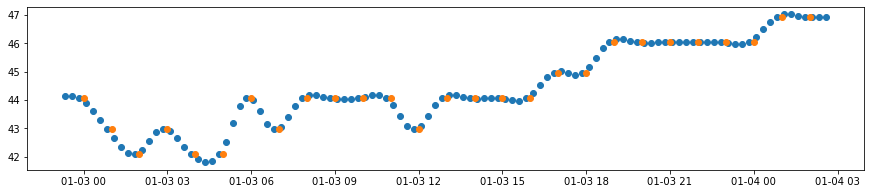

In [17]:
plt.figure(figsize=(15,3))

plt.scatter(bin_int_weather_hist.index[190:300], bin_int_weather_hist.temp[190:300])
plt.scatter(bin_int_weather_hist.time[190:300], bin_int_weather_hist.temp[190:300])

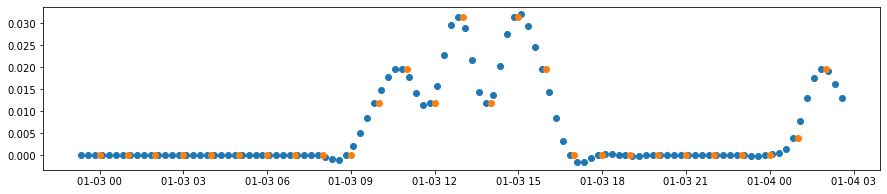

In [18]:
plt.figure(figsize=(15,3))

plt.scatter(bin_int_weather_hist.index[190:300], bin_int_weather_hist.rain_1h[190:300])
plt.scatter(bin_int_weather_hist.time[190:300], bin_int_weather_hist.rain_1h[190:300])

In [19]:
output_file = os.path.join(root_dir, 'data', 'binned_weather_history.csv')

bin_int_weather_hist.to_csv(output_file)